In [1]:
# loads a classic network
# converts it to FGN
# examine results over random noise
# train converted model and re-examine

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown               Tue Jul 14 15:47:05 2020  418.87.01
[0] GeForce RTX 2080 Ti | 48'C,   0 % |  8495 / 10989 MB | felix(775M) felix(7709M)
[1] GeForce RTX 2080 Ti | 50'C,   0 % |  6966 / 10988 MB | felix(5235M) felix(775M) felix(775M) root(169M)


In [6]:
# Define what device we are using

# manualy set cuda device
torch.cuda.set_device(1)

print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)


CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size = 1000
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=batch_size, 
                                                                                   batch_size_for_val=10000)

In [9]:
# create random noisy images
rand_shuffled_dataloader = fgnh.mnist_random_shuffled_dataloader(num_samples=10000, batch_size=10000)
rand_noise_dataloader = fgnh.mnist_random_dataloader(num_samples=10000, batch_size=10000)

<IPython.core.display.Javascript object>


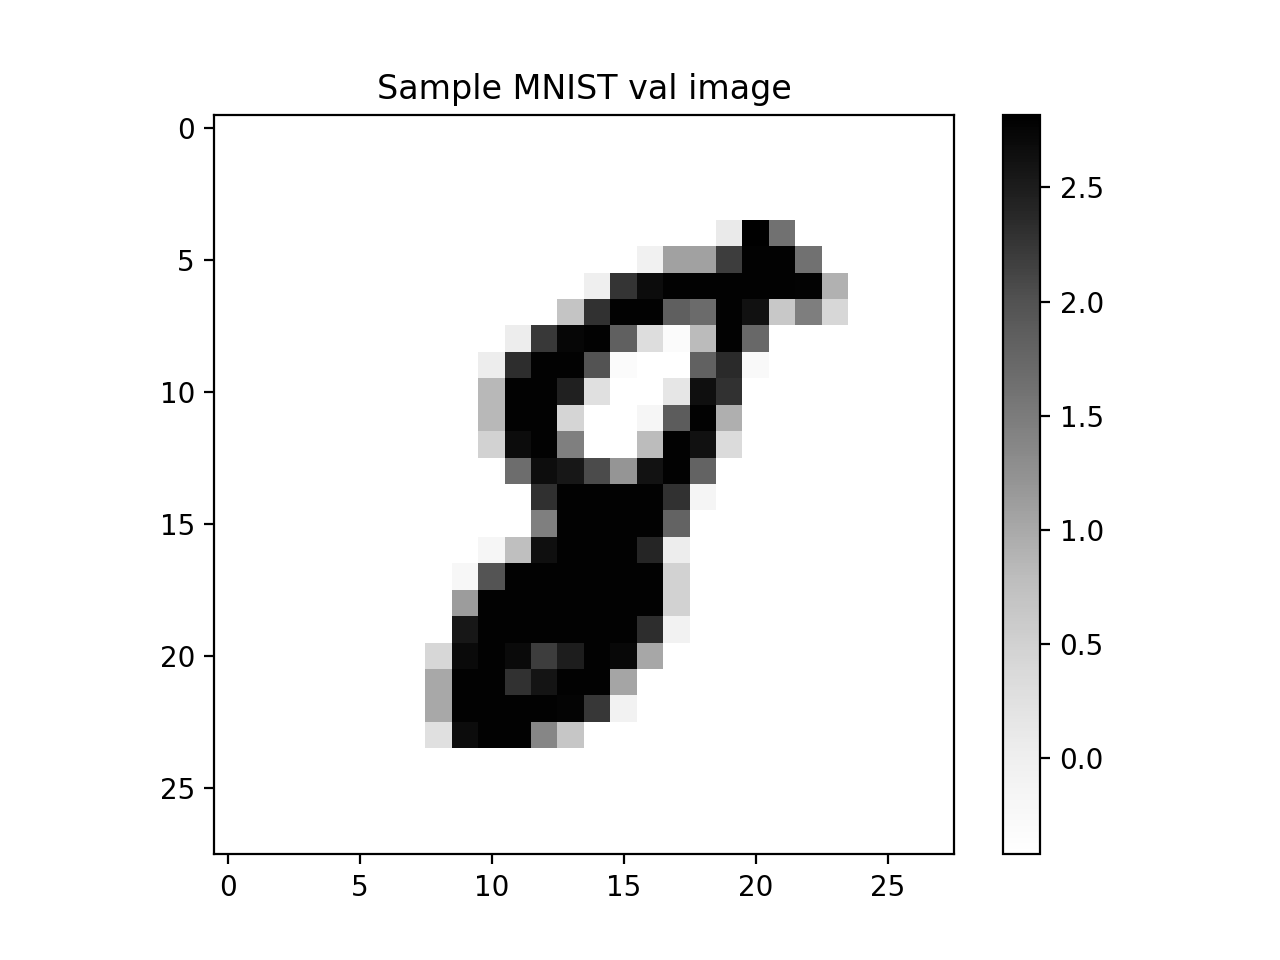

<IPython.core.display.Javascript object>


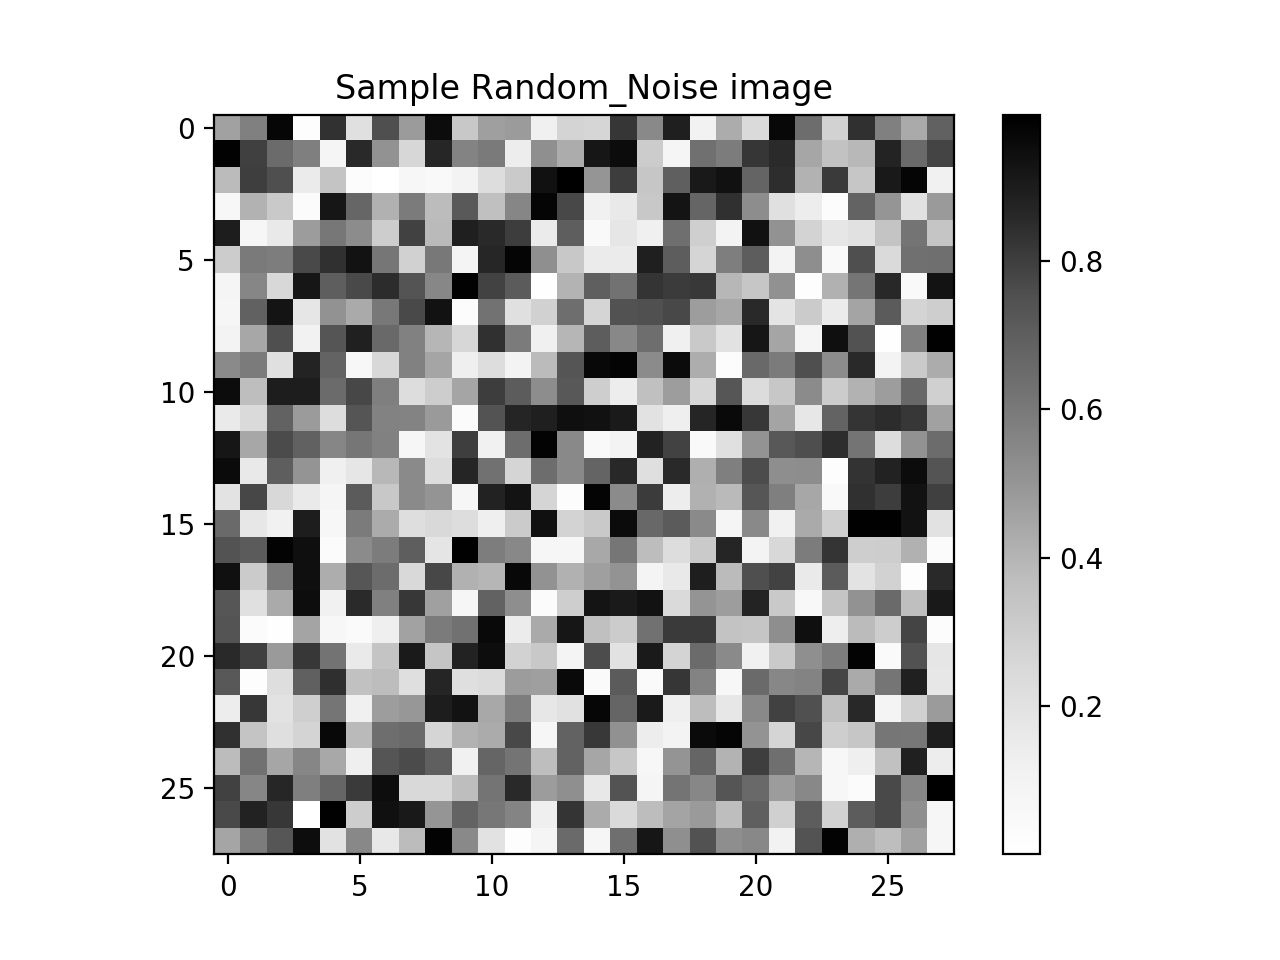

<IPython.core.display.Javascript object>


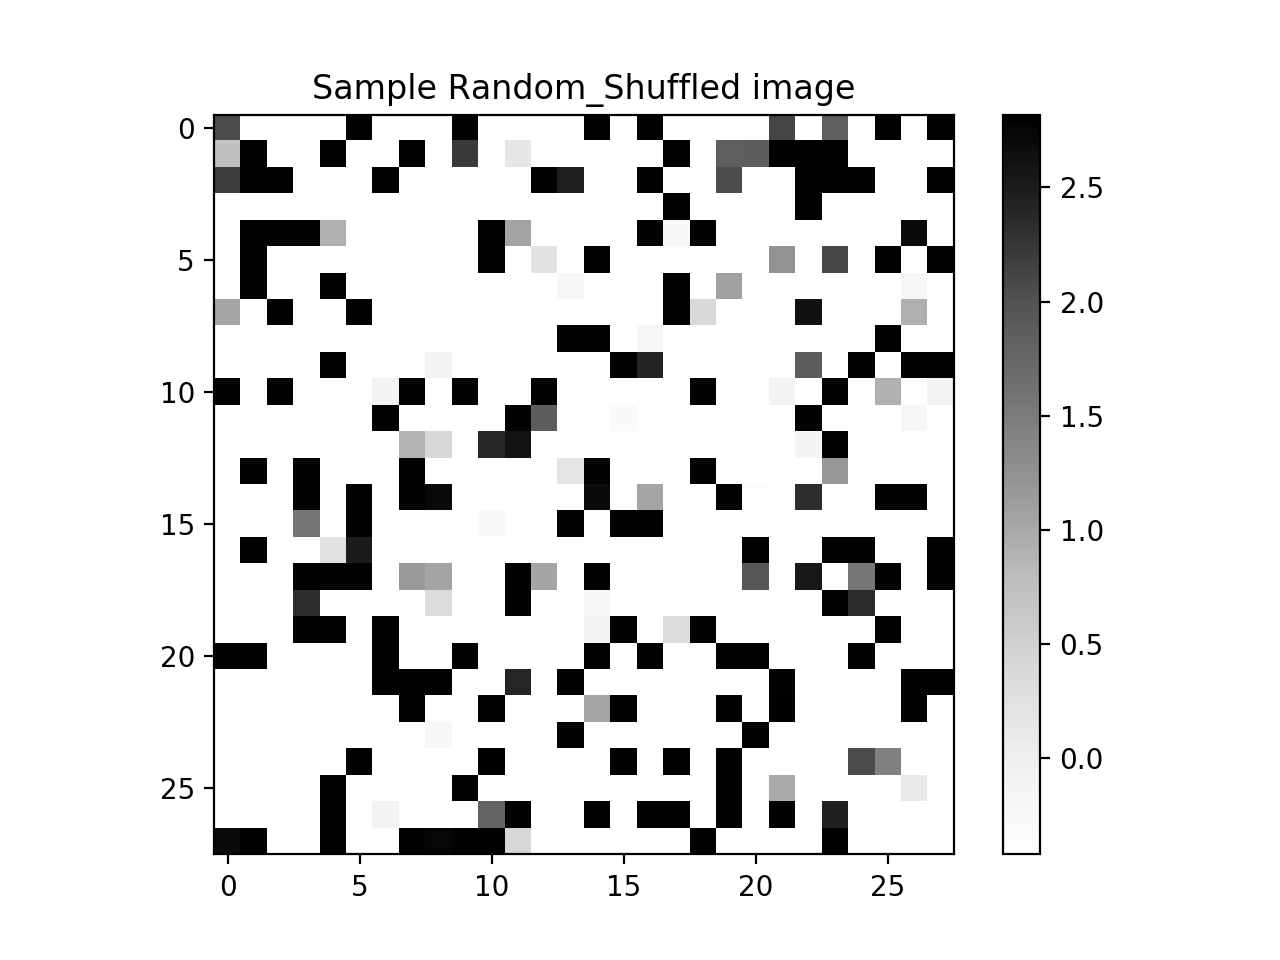

In [10]:
# plot samples
fgnh.plot_sample(mnist_val_loader, title='Sample MNIST val image')
fgnh.plot_sample(rand_noise_dataloader, title='Sample Random_Noise image')
fgnh.plot_sample(rand_shuffled_dataloader, title='Sample Random_Shuffled image')

# PART 1 - classic model 

In [11]:
# load a classic model
classic_model_path = '../Experiments/sample_models/sample_classic_full.pth'
classic_model = torch.load(classic_model_path)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# test the accuracy of the model
test_res = fgnh.test(classic_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(classic_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0319, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0933, Accuracy: 9739/10000 (97%)


<IPython.core.display.Javascript object>


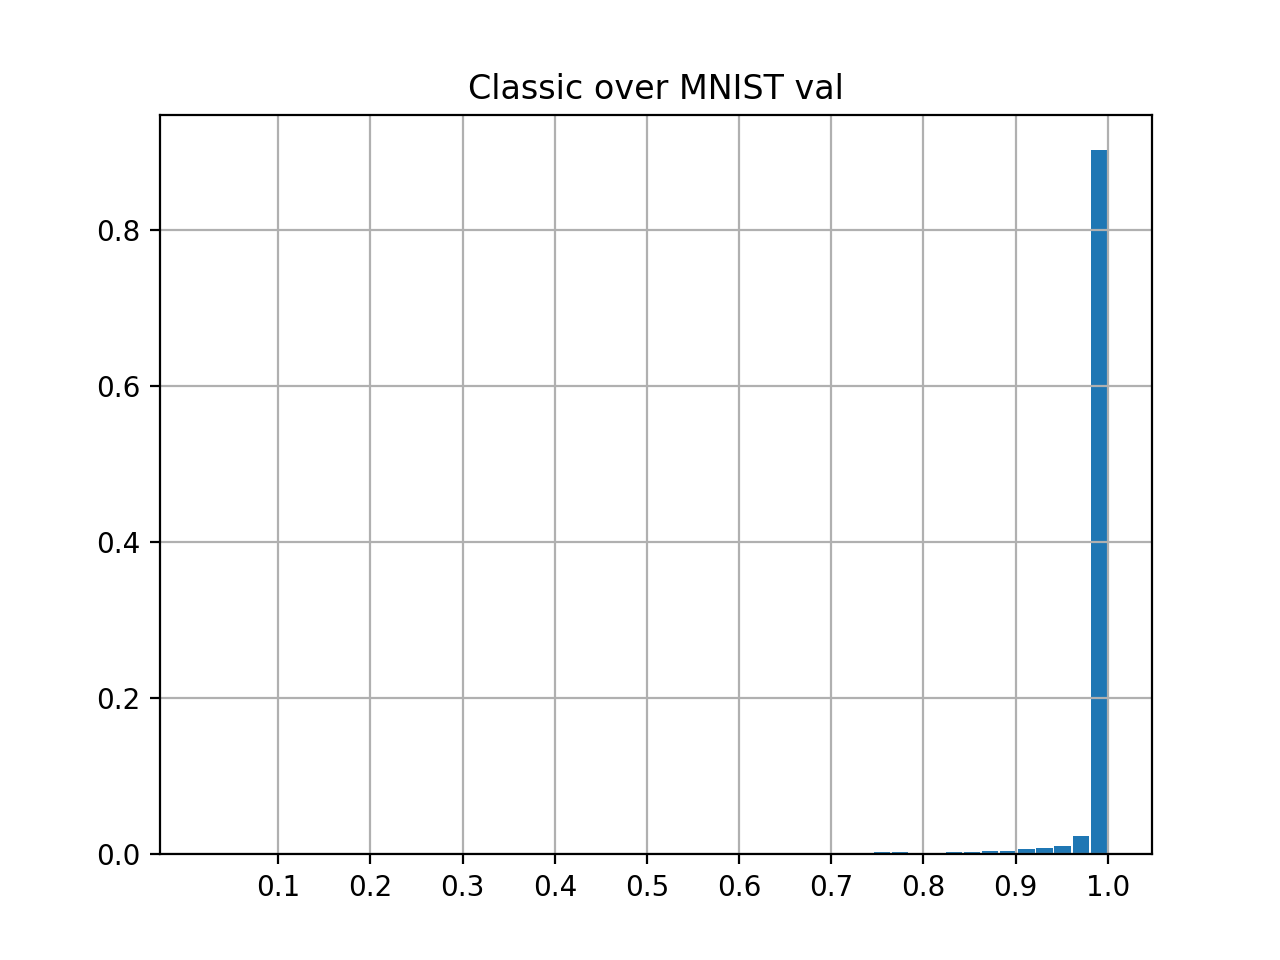

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29281412284330004853, 0.99999246479338905927), mean=0.98223500411359187715, variance=0.004917733732268505883, skewness=-5.3998289499540299548, kurtosis=31.40761362080887175)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 6297 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
index 4811 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 1042 prediction [0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.99]
index 294 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 9756 prediction [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
fgnh.plot_pred_histogram(classic_model, mnist_val_loader, title='Classic over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


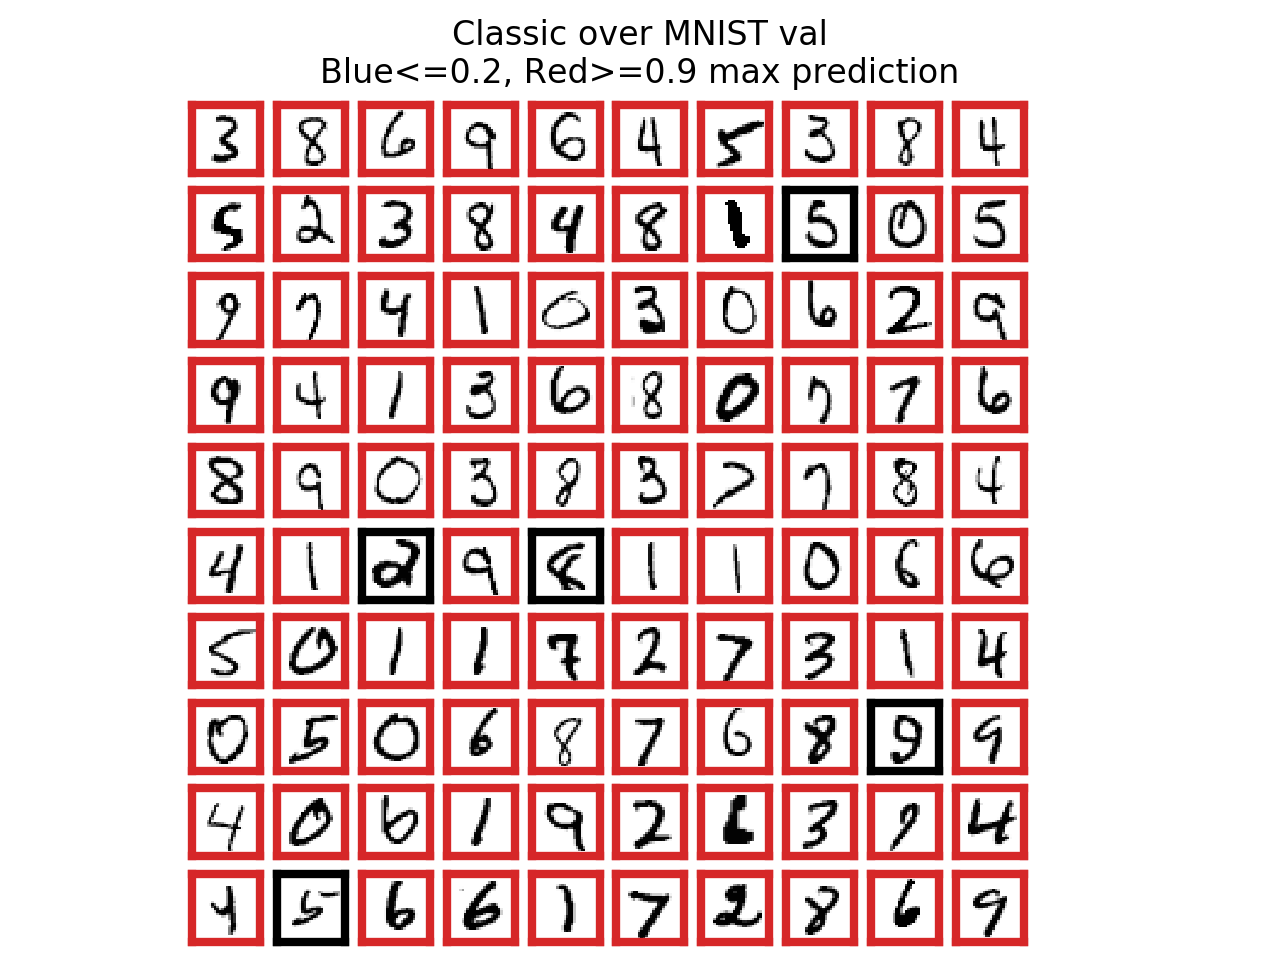

In [14]:
fgnh.plot_pred_samples_grid(classic_model, mnist_val_loader, title='Classic over MNIST val')

In [15]:
# over noise now

<IPython.core.display.Javascript object>


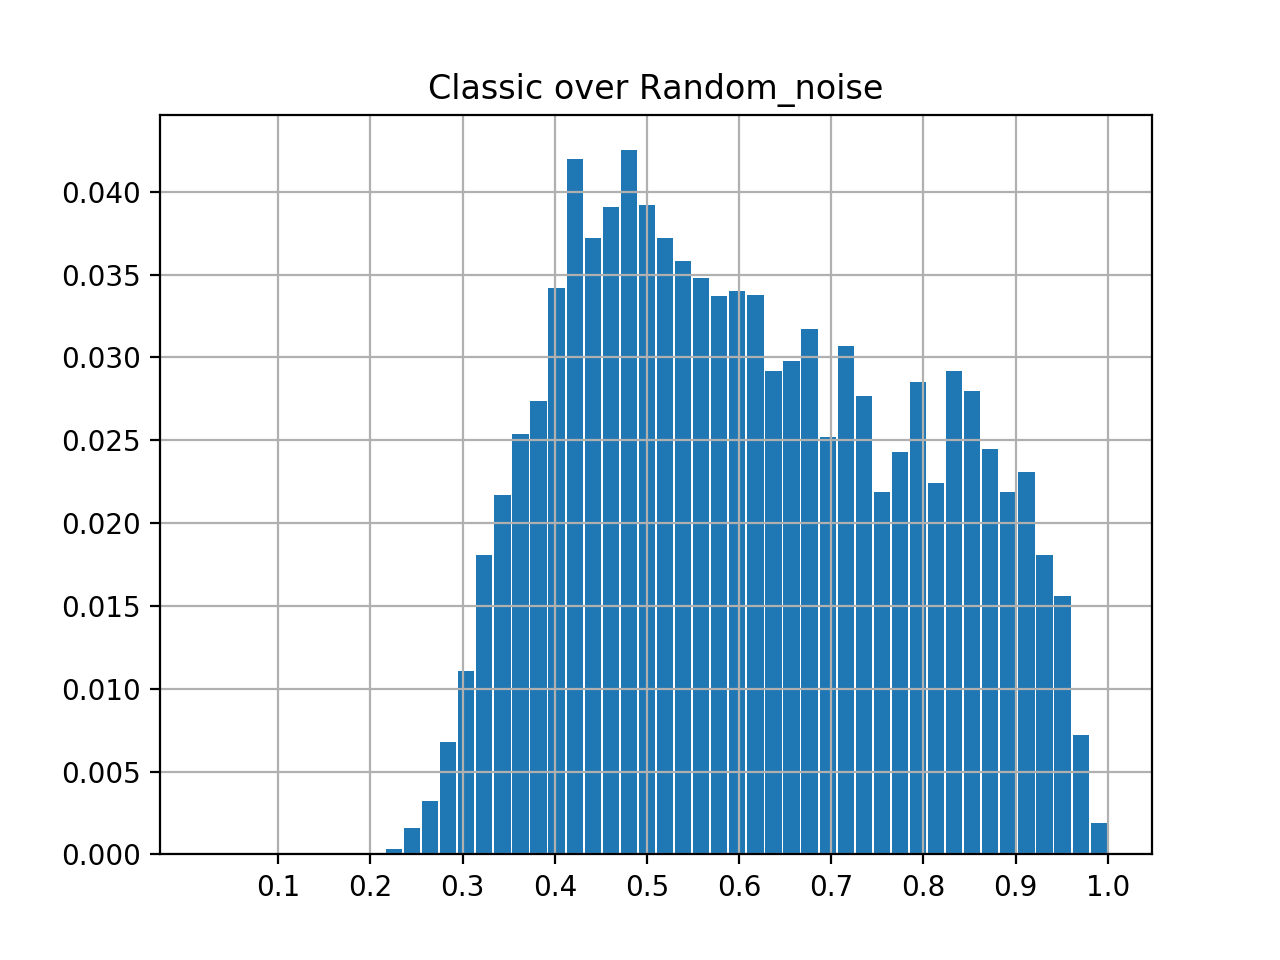

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.21775089117904584053, 0.9930331961548052788), mean=0.61084568828043965495, variance=0.032783418243972192263, skewness=0.18923349611332201406, kurtosis=-1.024592127476825679)

percentage of confident predictions (>=0.5): 0.6709

Sample predictions
index 4114 prediction [0.07 0.   0.   0.08 0.   0.62 0.21 0.   0.01 0.  ]
index 2555 prediction [0.01 0.06 0.09 0.2  0.   0.59 0.02 0.01 0.   0.  ]
index 8821 prediction [0.12 0.02 0.05 0.42 0.   0.01 0.   0.37 0.   0.01]
index 6034 prediction [0.19 0.   0.62 0.16 0.   0.01 0.01 0.01 0.   0.  ]
index 9729 prediction [0.   0.33 0.03 0.23 0.   0.16 0.   0.25 0.   0.  ]


In [16]:
fgnh.plot_pred_histogram(classic_model, rand_noise_dataloader, title='Classic over Random_noise' ,verbose=True)

<IPython.core.display.Javascript object>


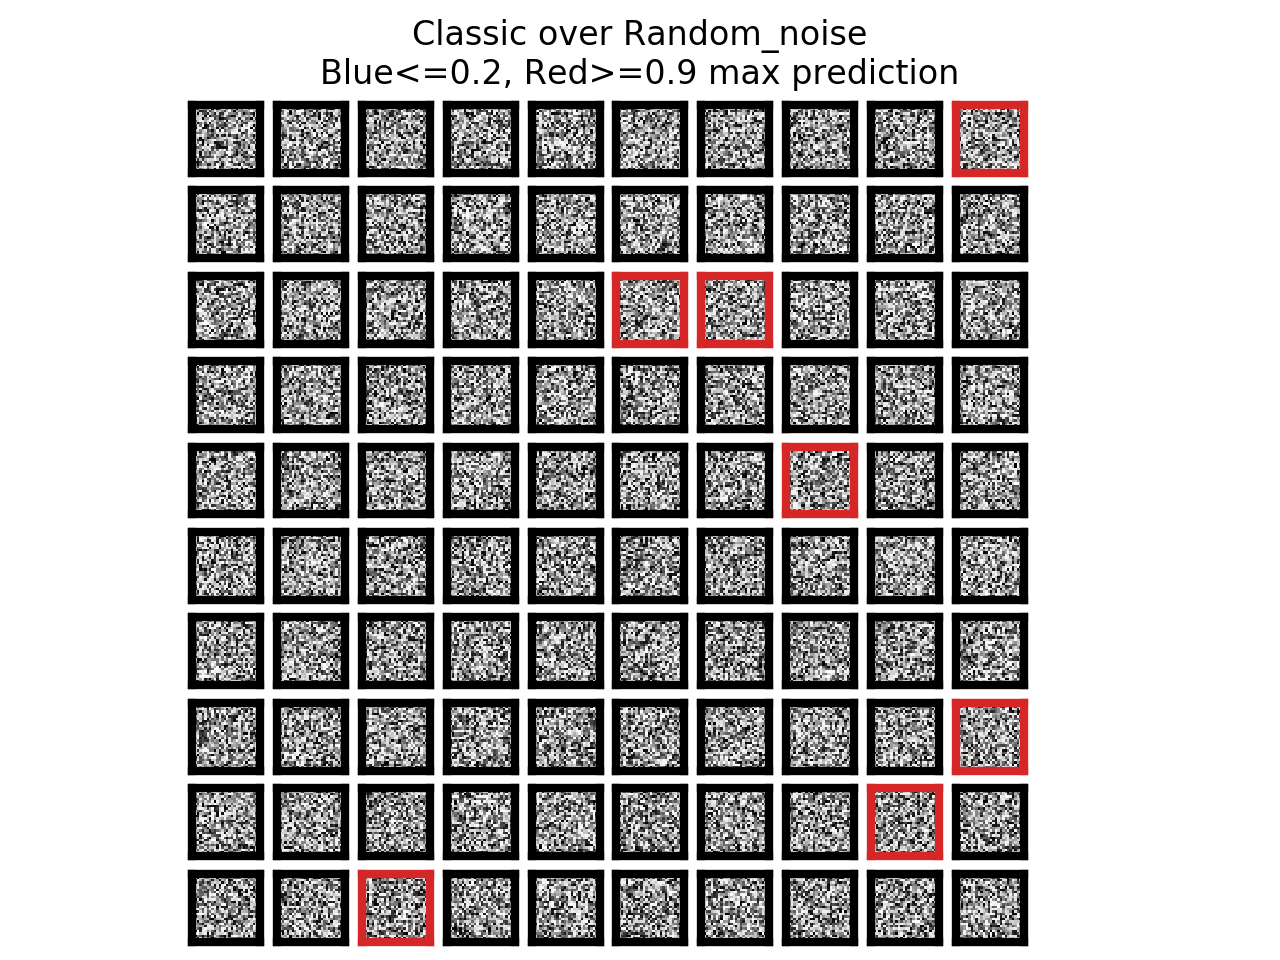

In [17]:
fgnh.plot_pred_samples_grid(classic_model, rand_noise_dataloader, title='Classic over Random_noise')

<IPython.core.display.Javascript object>


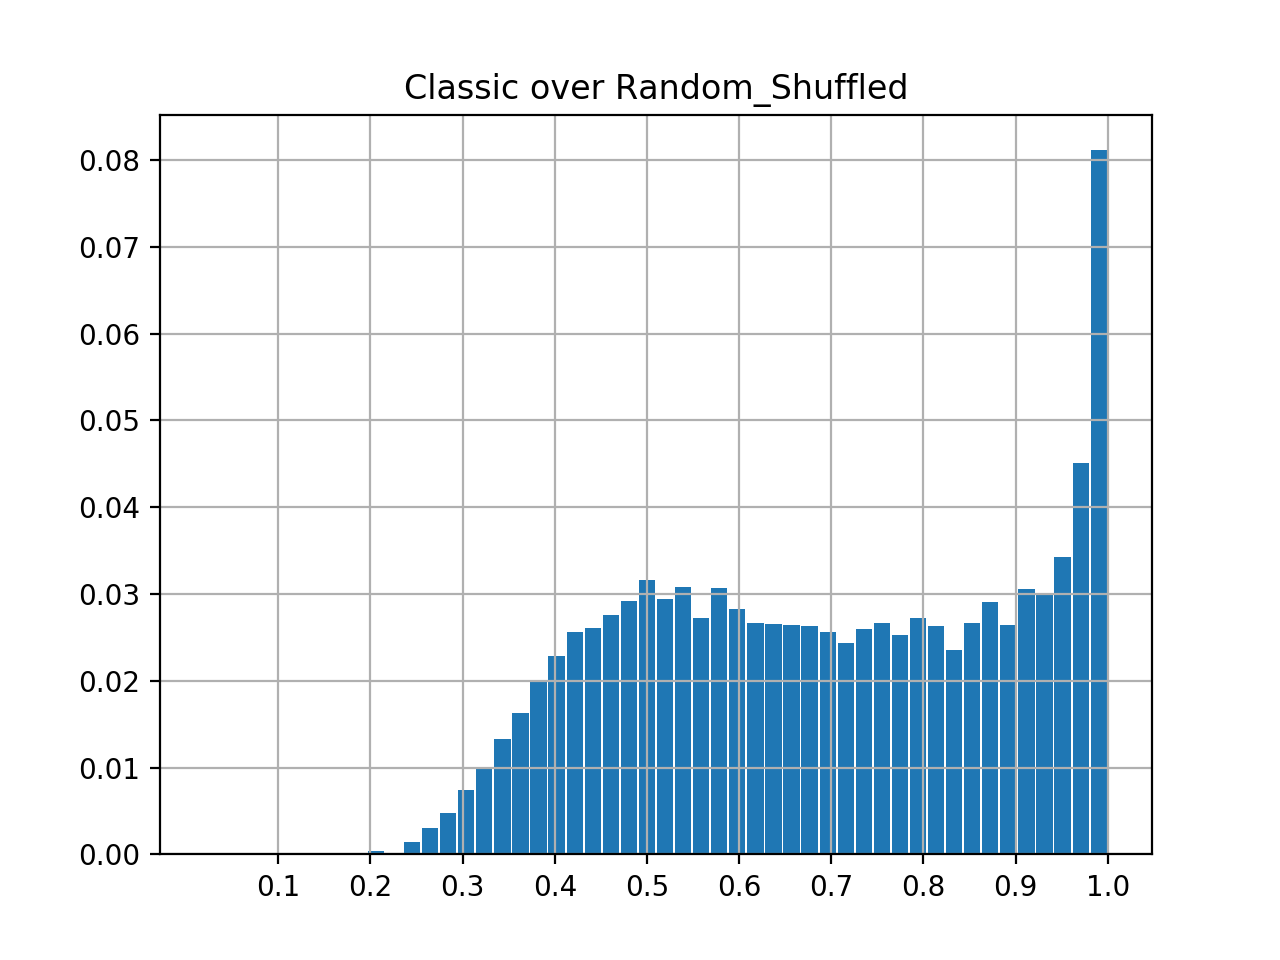

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.2003514826362789788, 0.9998597711762015237), mean=0.69164794230932826667, variance=0.04237328124209462272, skewness=-0.105749086274147857174, kurtosis=-1.1938406327273595673)

percentage of confident predictions (>=0.5): 0.7758

Sample predictions
index 6027 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6530 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.01]
index 307 prediction [0.   0.86 0.   0.   0.   0.   0.   0.13 0.   0.  ]
index 8230 prediction [0.   0.29 0.02 0.08 0.   0.31 0.   0.29 0.   0.  ]
index 6781 prediction [0.   0.19 0.04 0.13 0.   0.1  0.   0.53 0.   0.01]


In [18]:
fgnh.plot_pred_histogram(classic_model, rand_shuffled_dataloader, title='Classic over Random_Shuffled' ,verbose=True)

<IPython.core.display.Javascript object>


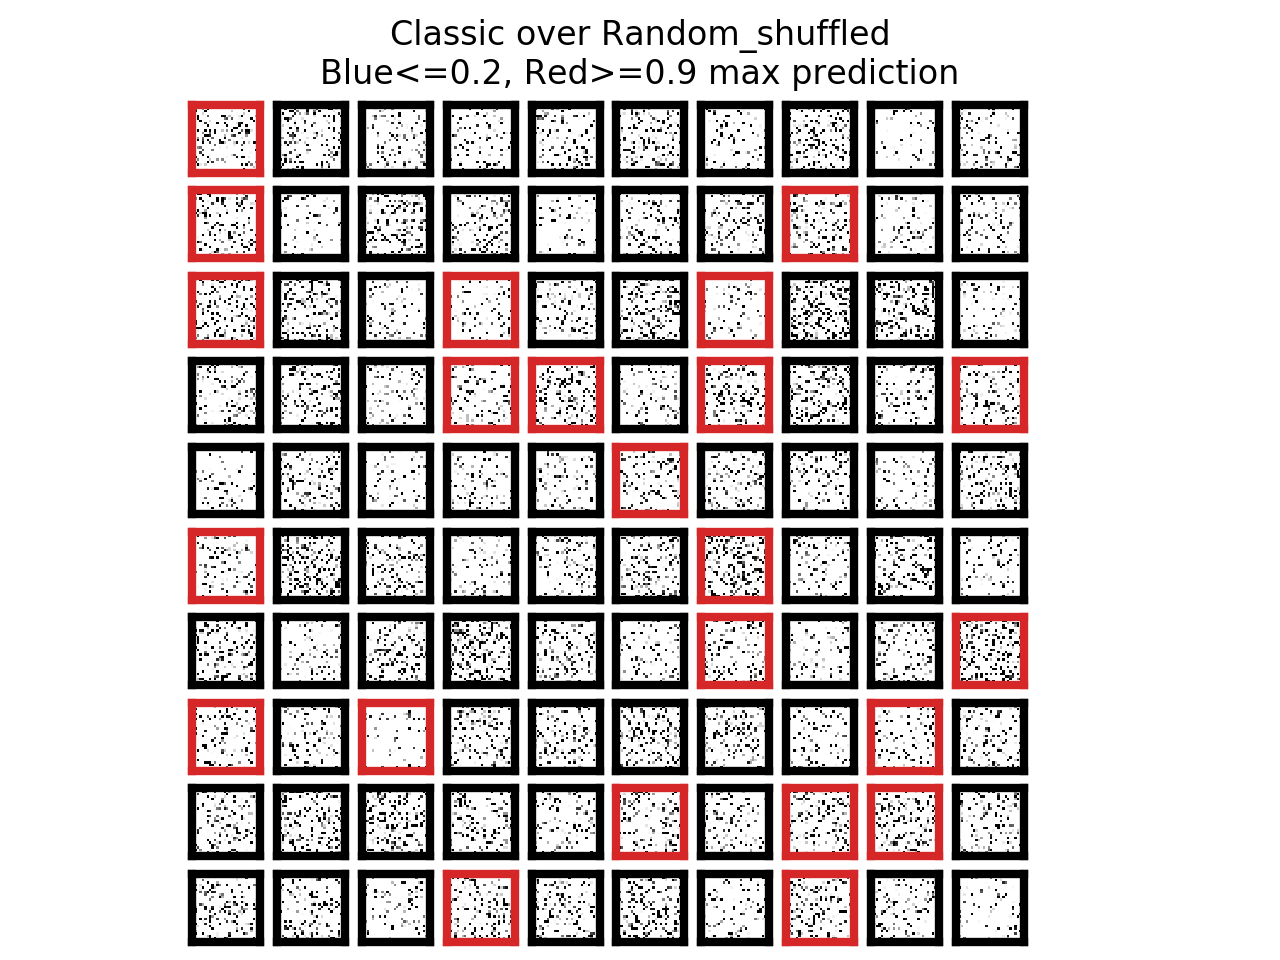

In [19]:
fgnh.plot_pred_samples_grid(classic_model, rand_shuffled_dataloader, title='Classic over Random_shuffled')

# Part 2 - The converted Network

In [20]:
# print params to copy
!cat '../Experiments/sample_models/sample_classic_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [21]:
# params from classic
hidden_layer_sizes = [64,64]
drop_p = 0.2
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)

# fgn specific params
# covariance type: sphere, diag or full/chol
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

hidden layers: [64, 64]
drop prob: 0.2
covariance: sphere
ordinal for norm: 2.0
non linearity: True
free biases: True


In [22]:
# Initialize the fgn network
converted_fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)

In [23]:
converted_fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [24]:
# convert from classic network
fgnl.convert_classic_to_fgn(classic_model, converted_fgn_model, init_factor=1e2)

In [25]:
# set to eval mode
converted_fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [26]:
# test the accuracy of the model
# is it identical to above? (should be)
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.0319, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0933, Accuracy: 9739/10000 (97%)


<IPython.core.display.Javascript object>


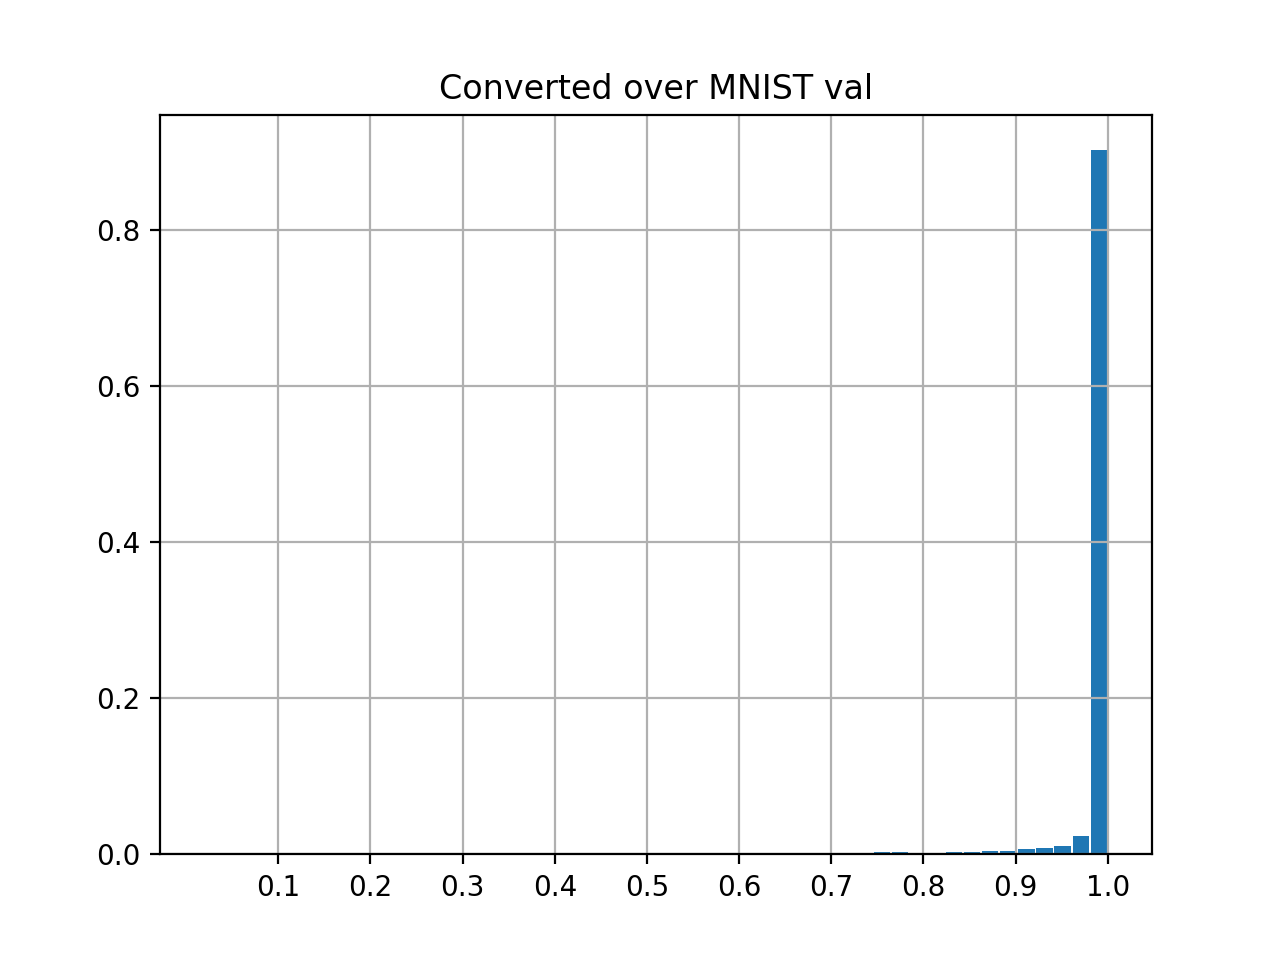

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.2928150964853718134, 0.9999924513425149171), mean=0.98223212537929560656, variance=0.0049180878434556488368, skewness=-5.3990504411428096435, kurtosis=31.396416864320905851)

percentage of confident predictions (>=0.5): 0.996

Sample predictions
index 5853 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7301 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 5609 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 3198 prediction [0.   0.   0.   0.   0.   0.01 0.99 0.   0.   0.  ]
index 3366 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Converted over MNIST val' ,verbose=True)

<IPython.core.display.Javascript object>


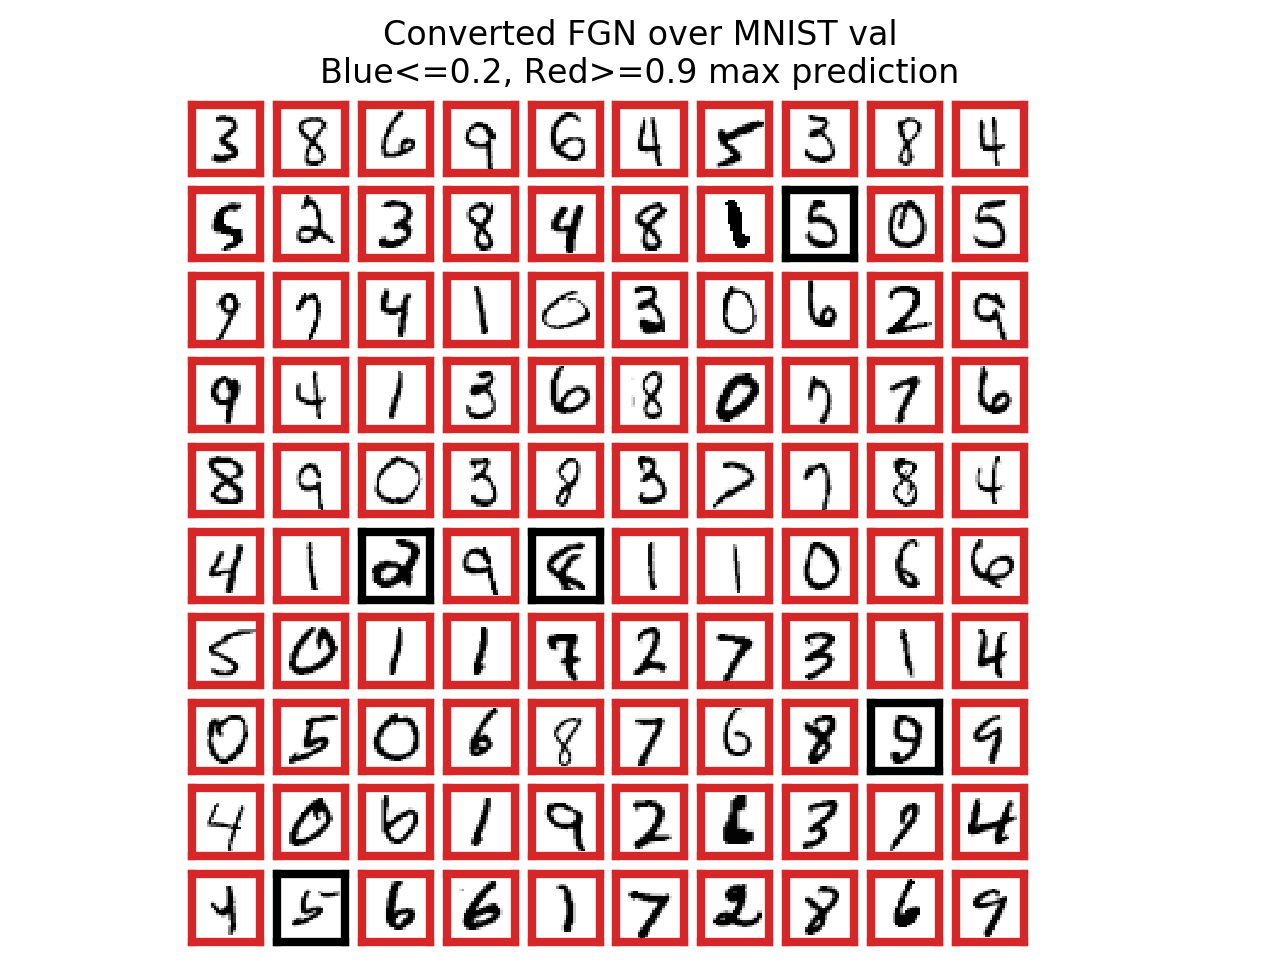

In [28]:
fgnh.plot_pred_samples_grid(converted_fgn_model, mnist_val_loader, title='Converted FGN over MNIST val')

<IPython.core.display.Javascript object>


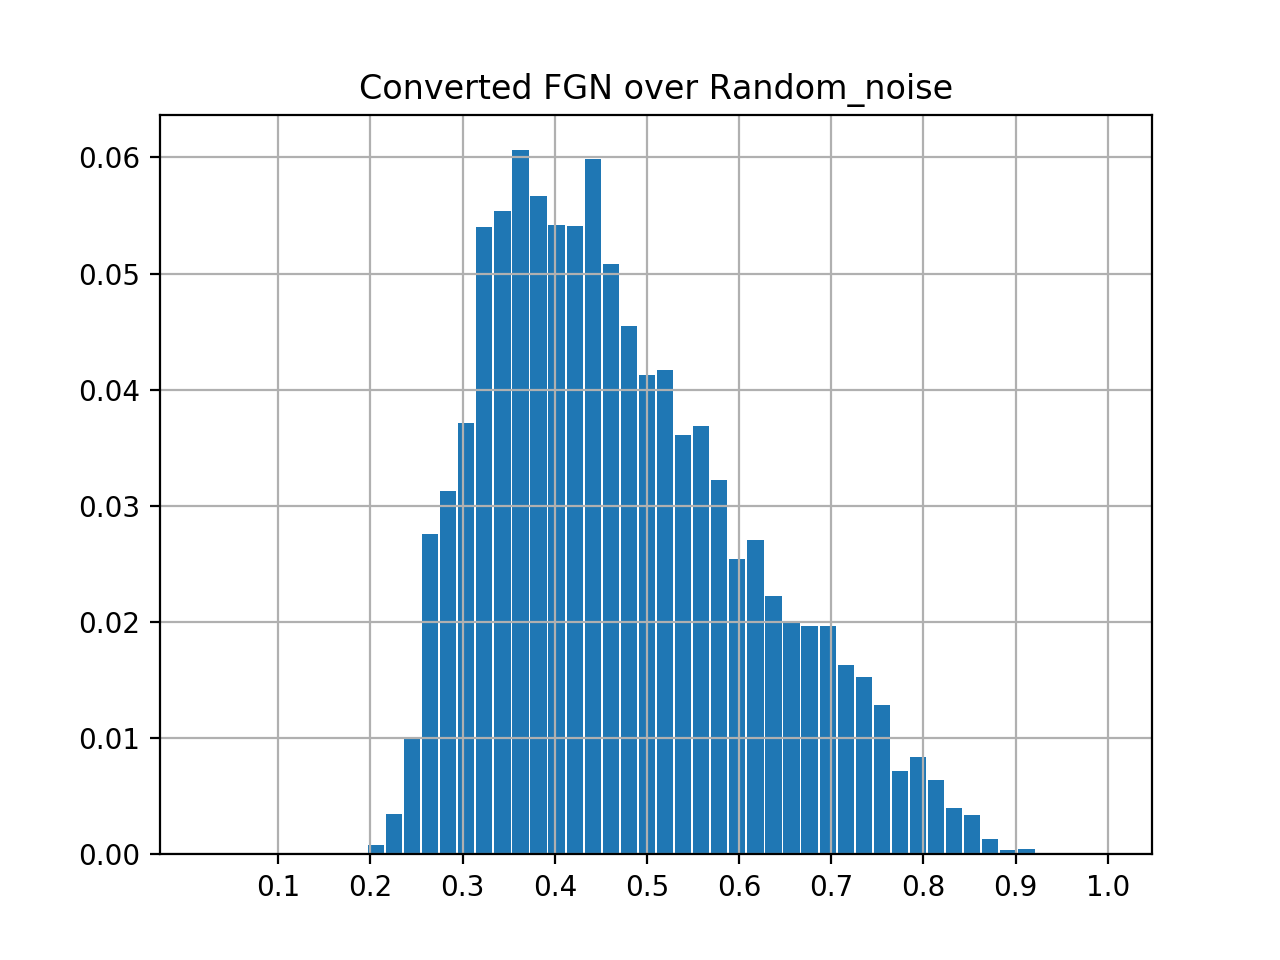

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.17320832725124867143, 0.92093346032787797516), mean=0.47290951688966297457, variance=0.019629483125312923862, skewness=0.57995303854589740636, kurtosis=-0.35356415061202030856)

percentage of confident predictions (>=0.5): 0.3775

Sample predictions
index 9277 prediction [0.04 0.05 0.06 0.52 0.   0.27 0.03 0.03 0.01 0.  ]
index 1393 prediction [0.2  0.14 0.07 0.32 0.   0.16 0.06 0.03 0.01 0.  ]
index 8390 prediction [0.   0.63 0.13 0.09 0.   0.01 0.01 0.12 0.   0.  ]
index 9908 prediction [0.01 0.43 0.31 0.09 0.   0.02 0.03 0.11 0.   0.  ]
index 7800 prediction [0.04 0.01 0.02 0.48 0.   0.37 0.04 0.03 0.01 0.  ]


In [29]:
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random_noise' ,verbose=True)

<IPython.core.display.Javascript object>


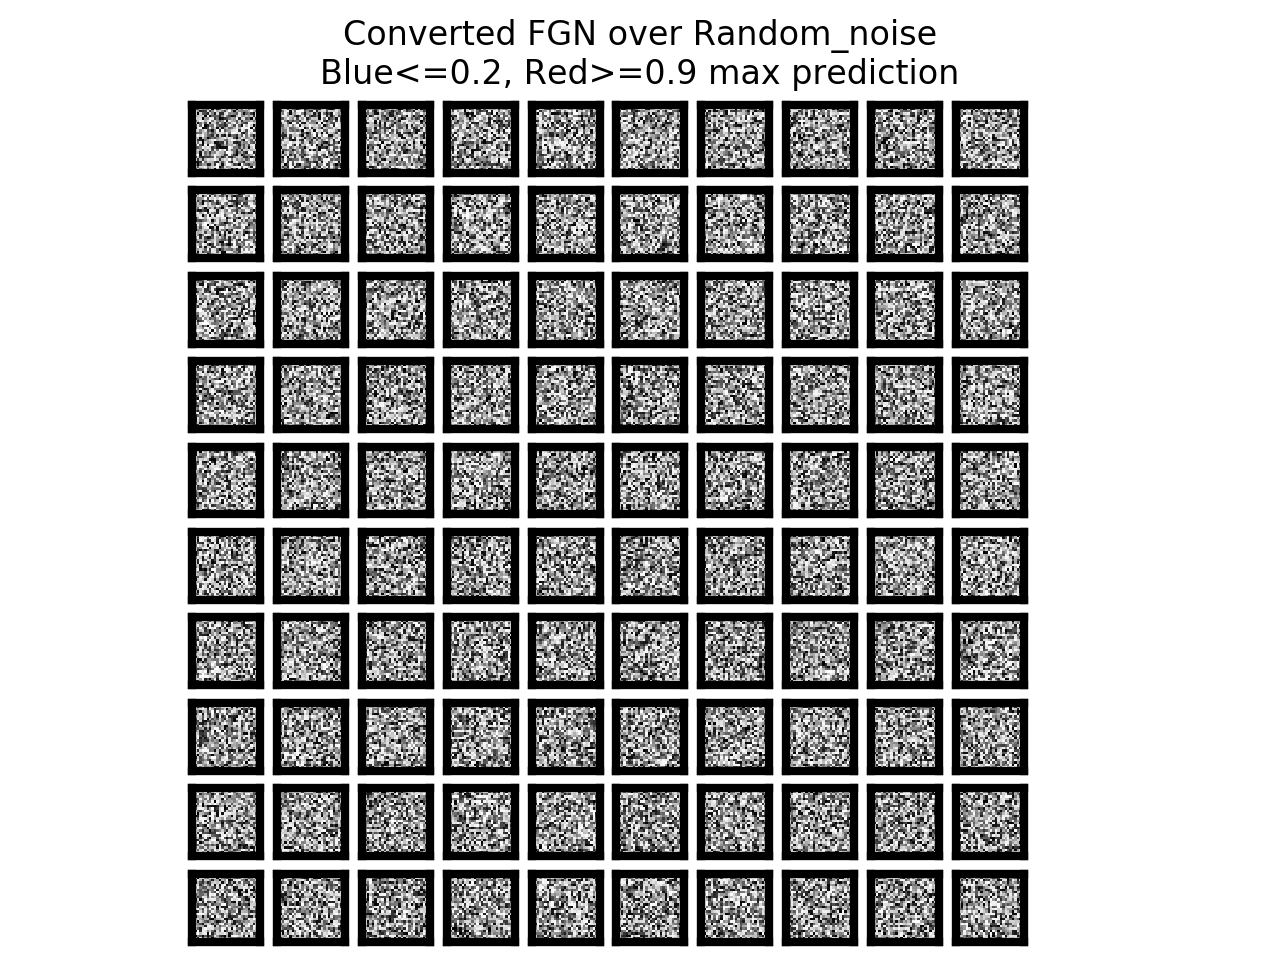

In [30]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random_noise')

<IPython.core.display.Javascript object>


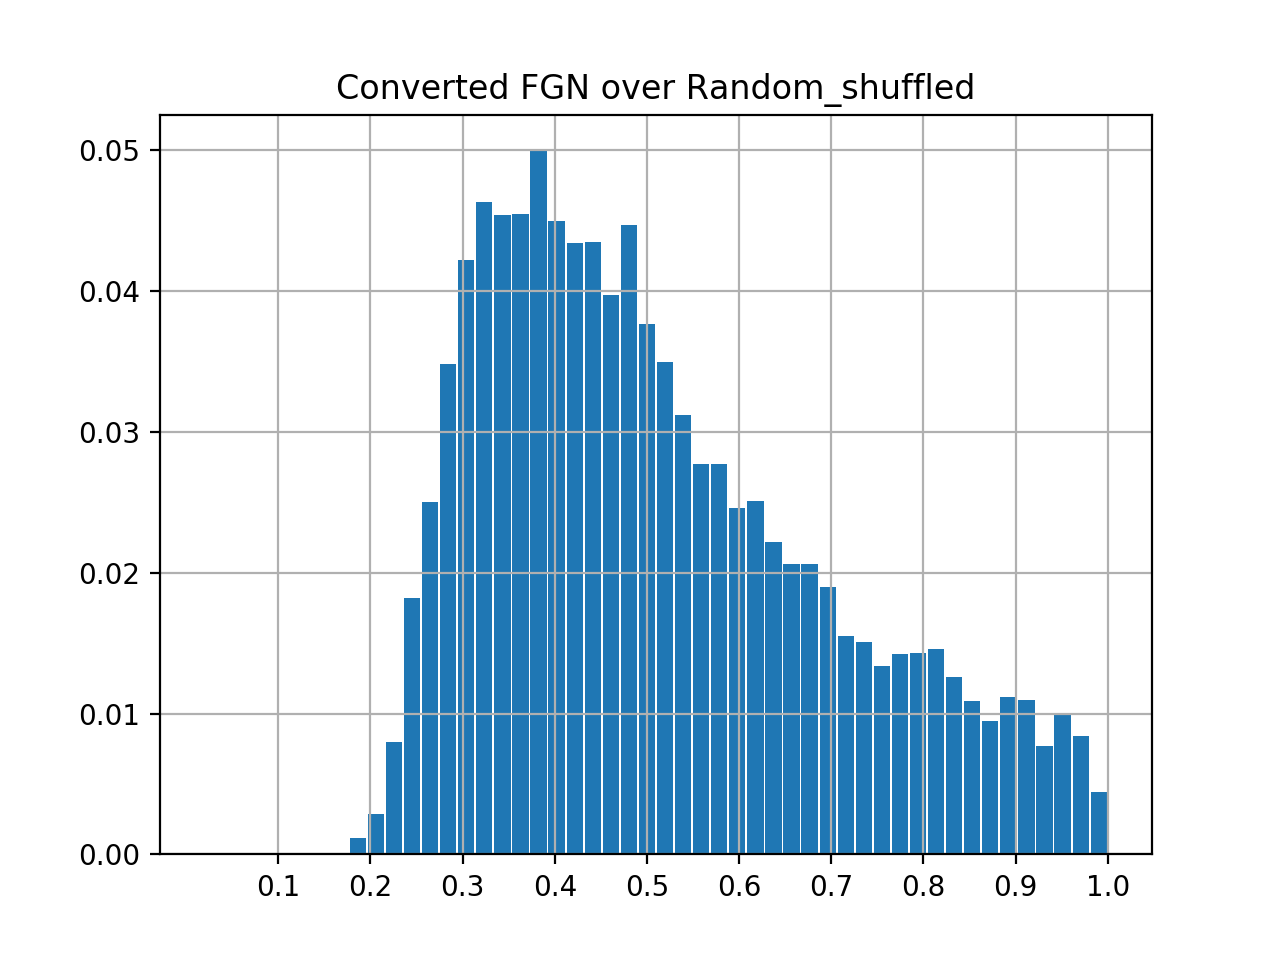

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.17183636413644074856, 0.99755289248596676837), mean=0.5120953008006273741, variance=0.035069496667006006553, skewness=0.67238266769209263836, kurtosis=-0.39286380852407594508)

percentage of confident predictions (>=0.5): 0.445

Sample predictions
index 6103 prediction [0.04 0.13 0.16 0.3  0.02 0.14 0.1  0.06 0.03 0.01]
index 7729 prediction [0.   0.65 0.14 0.14 0.   0.   0.   0.01 0.05 0.  ]
index 5488 prediction [0.05 0.06 0.09 0.09 0.02 0.05 0.01 0.61 0.01 0.01]
index 9405 prediction [0.03 0.01 0.02 0.17 0.14 0.09 0.01 0.05 0.38 0.1 ]
index 8780 prediction [0.   0.02 0.02 0.11 0.   0.   0.   0.79 0.01 0.05]


In [31]:
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random_shuffled' ,verbose=True)

<IPython.core.display.Javascript object>


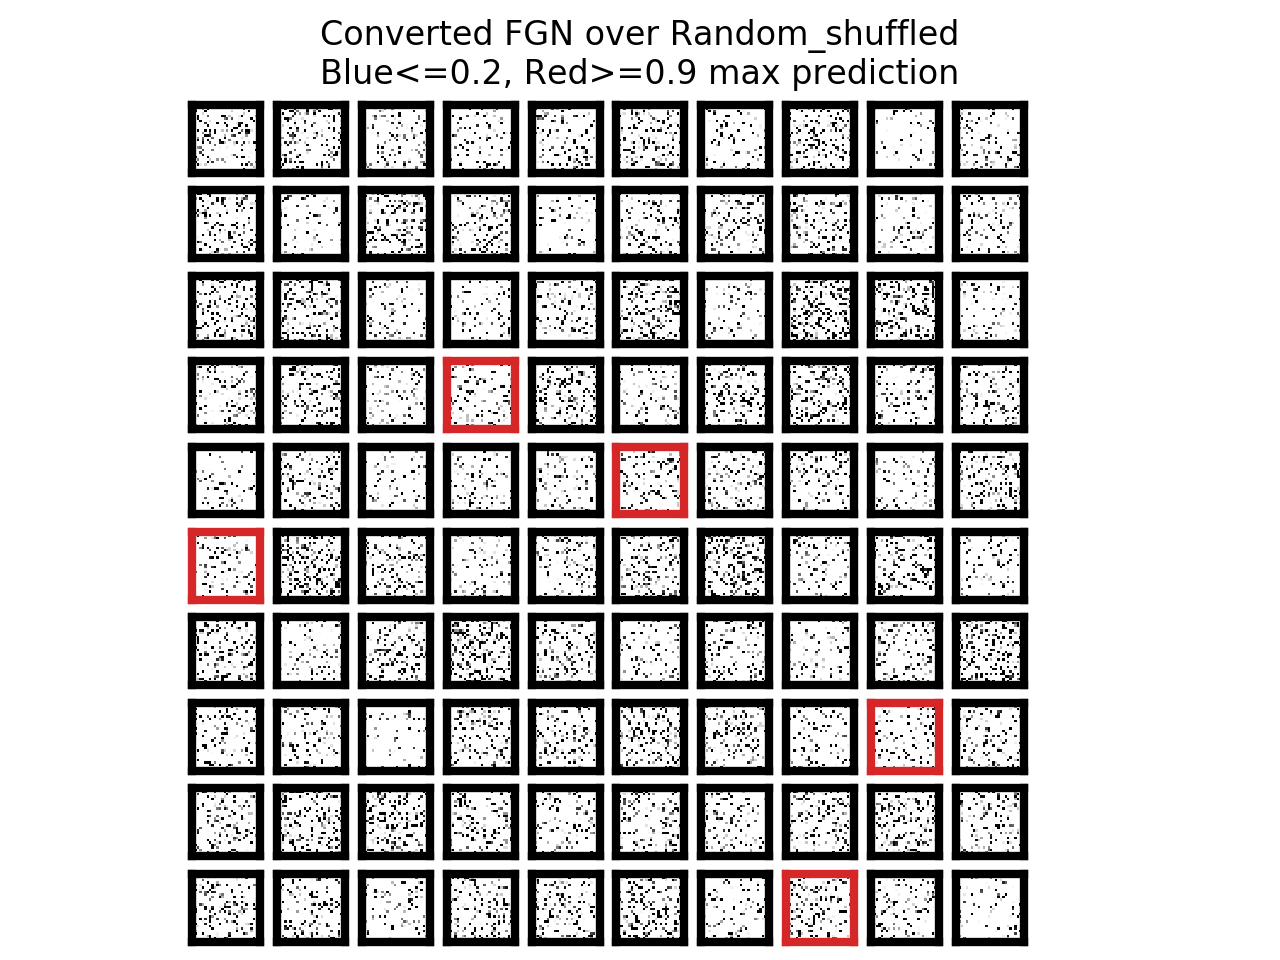

In [32]:
fgnh.plot_pred_samples_grid(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random_shuffled')

# Part 3 - Retraining

In [33]:
# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e1
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, converted_fgn_model.parameters()), lr=1e-3)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 10.0


In [34]:
# train the network for N epochs
epochs = 1
train_res = fgnh.train(converted_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 8190761.4828, Accuracy: 48400/50000 (97%)
Test set - Average loss: 255048.0000, Accuracy: 9753/10000 (98%)


<IPython.core.display.Javascript object>


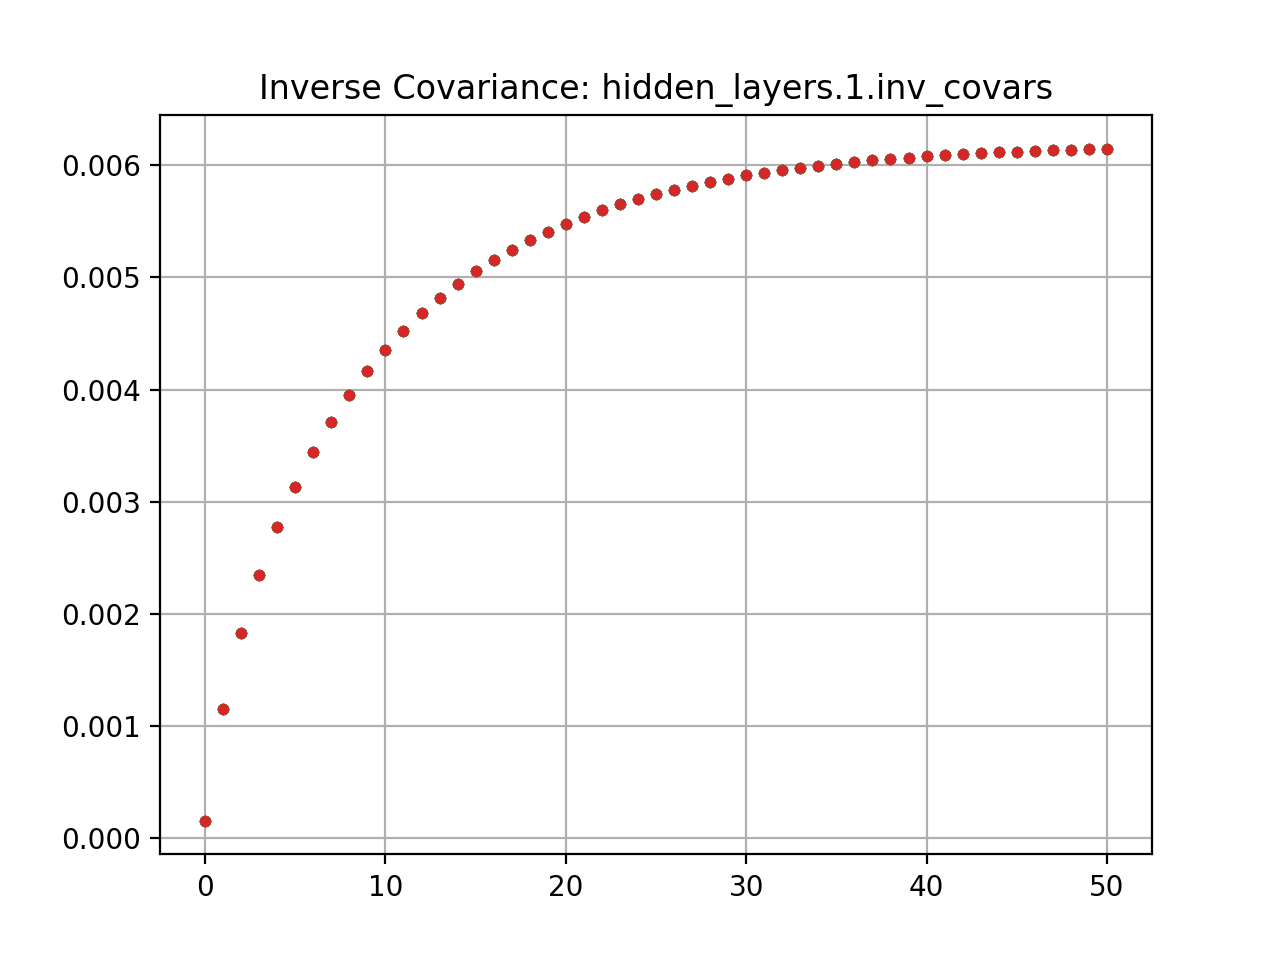

<IPython.core.display.Javascript object>


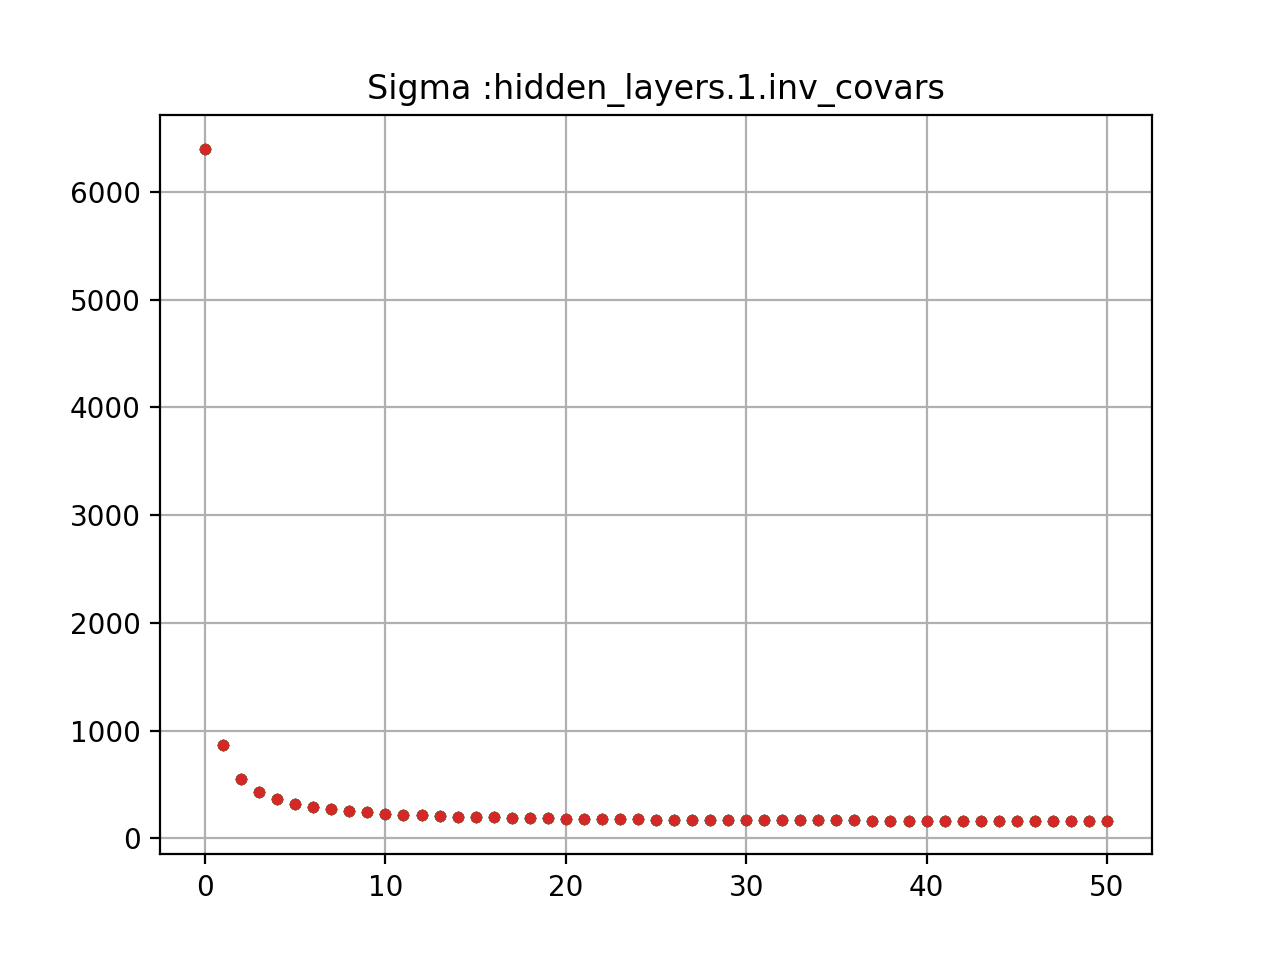

<IPython.core.display.Javascript object>


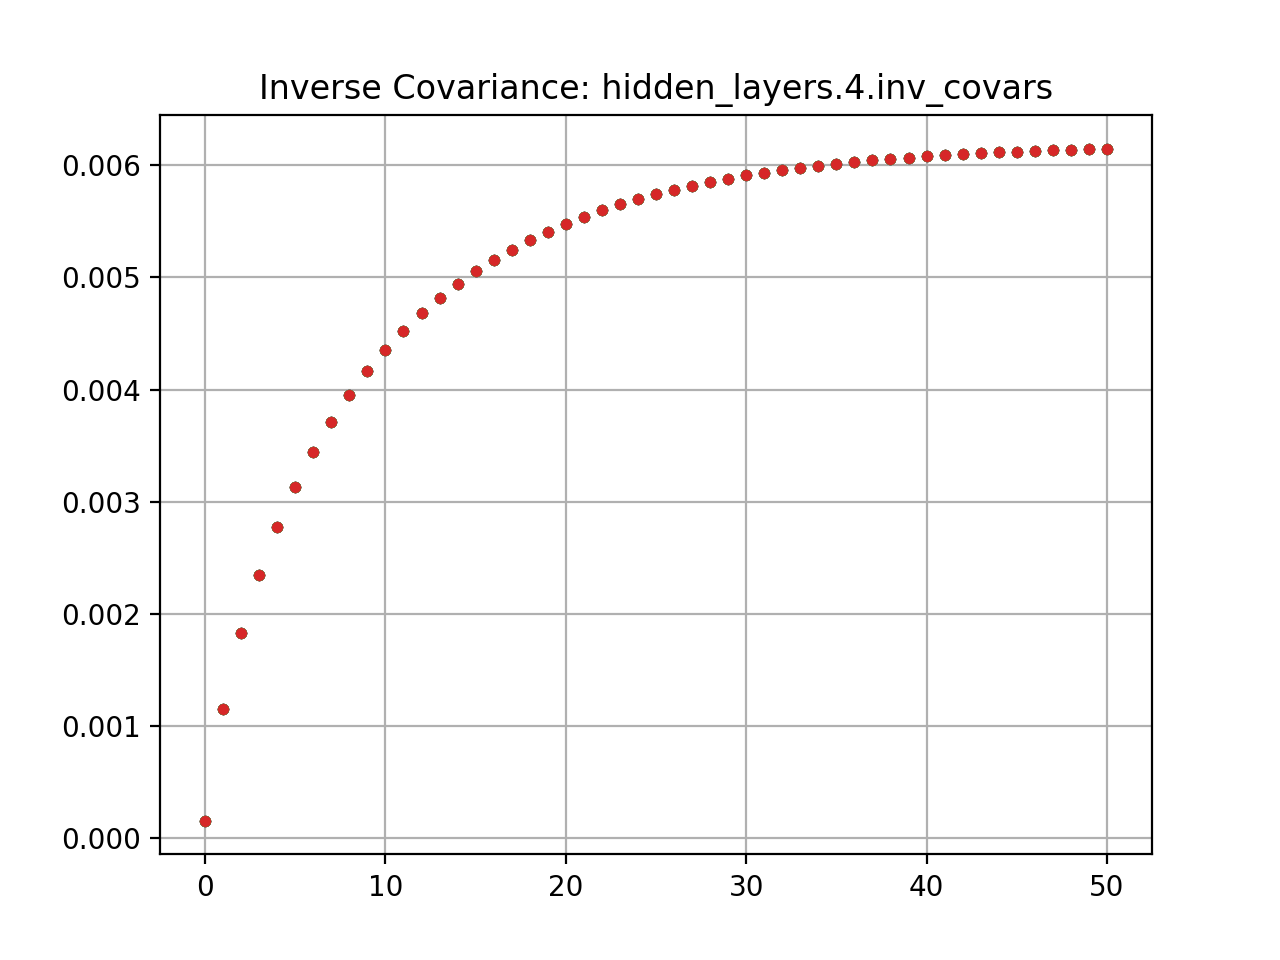

<IPython.core.display.Javascript object>


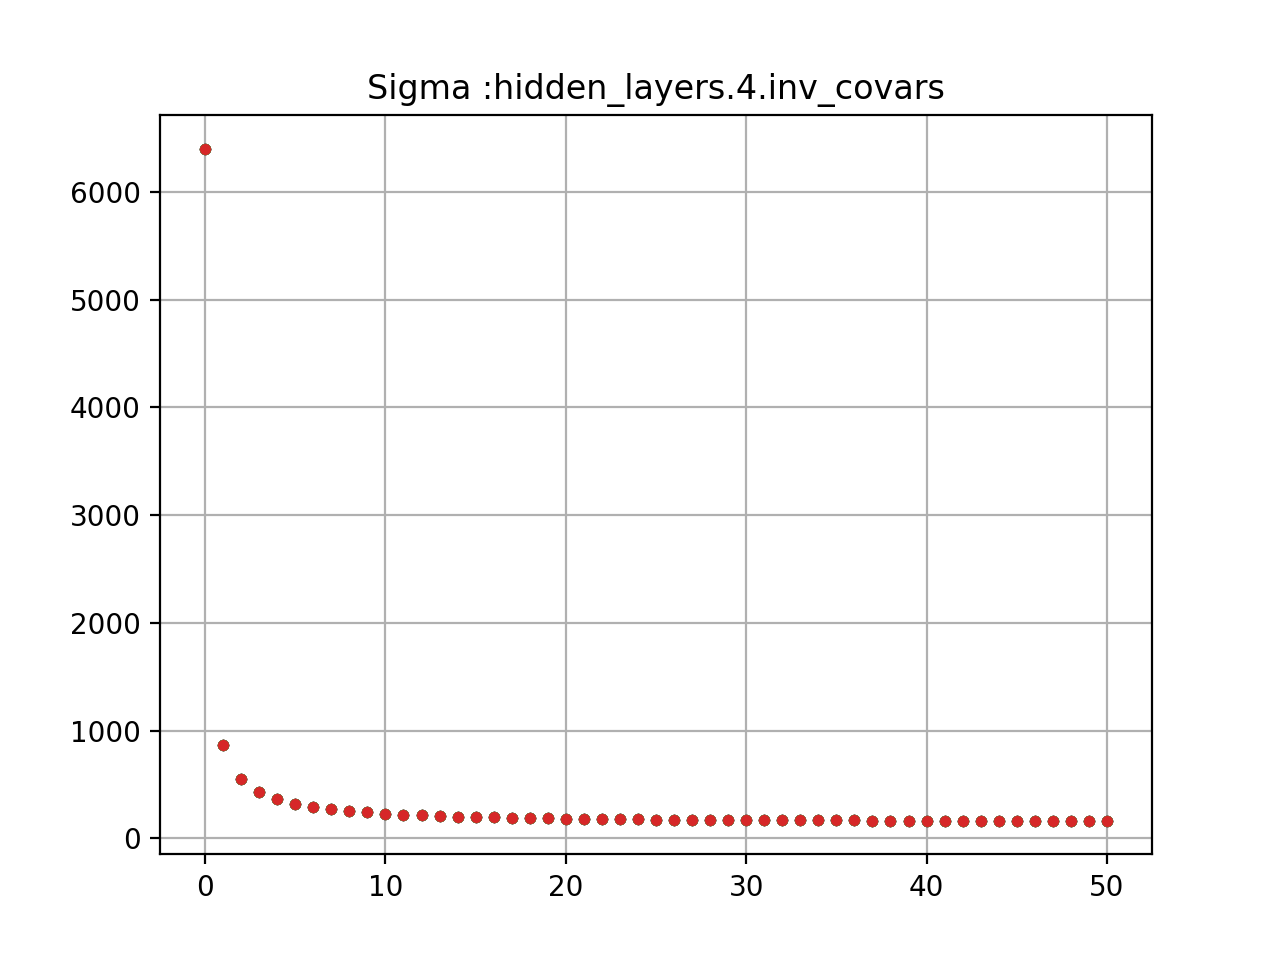

<IPython.core.display.Javascript object>


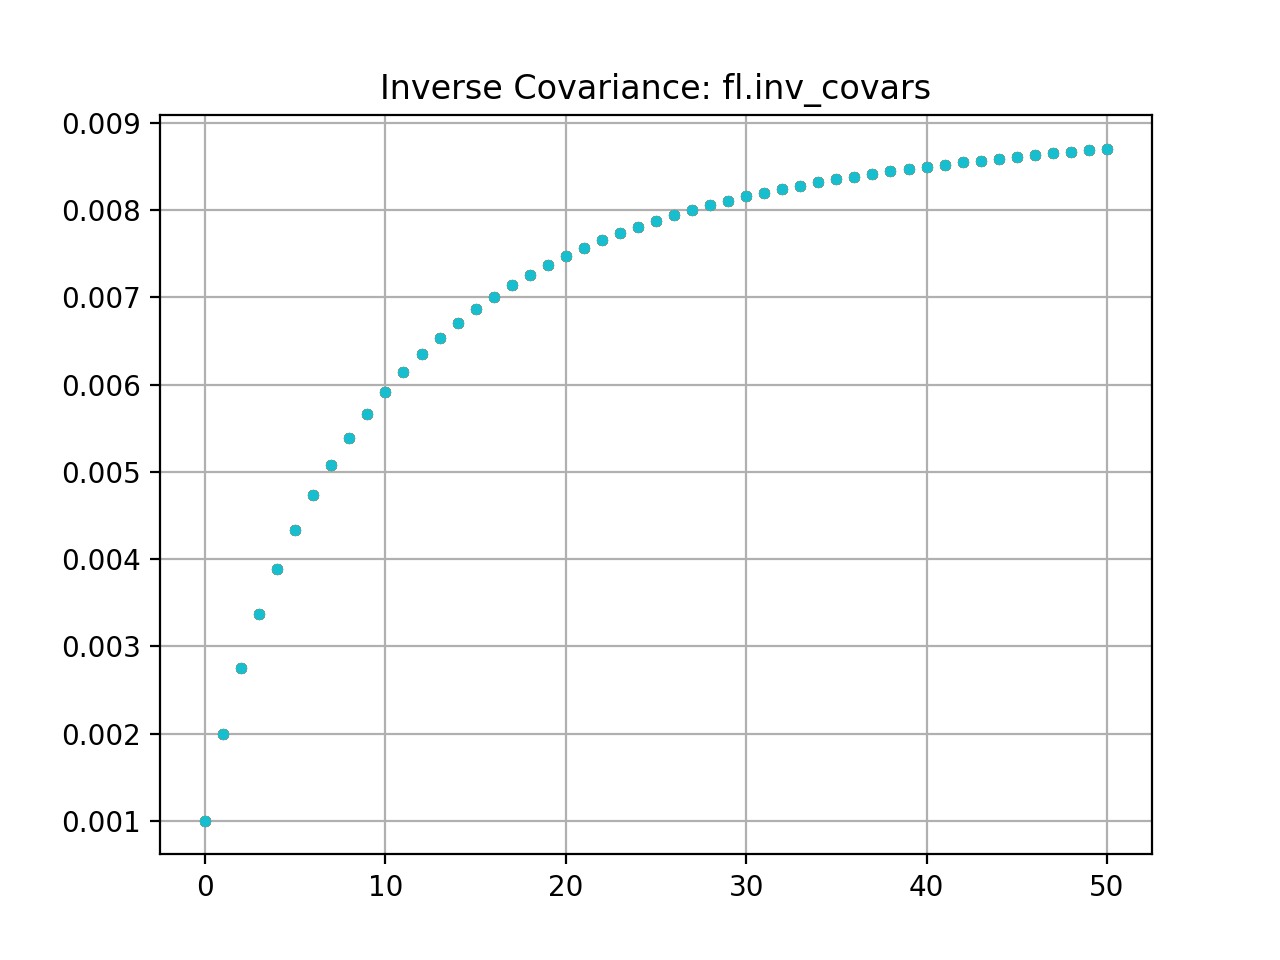

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/plot_sigmas_histories.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.plot(1.0/histories[k], marker='.', linestyle=' ')


<IPython.core.display.Javascript object>


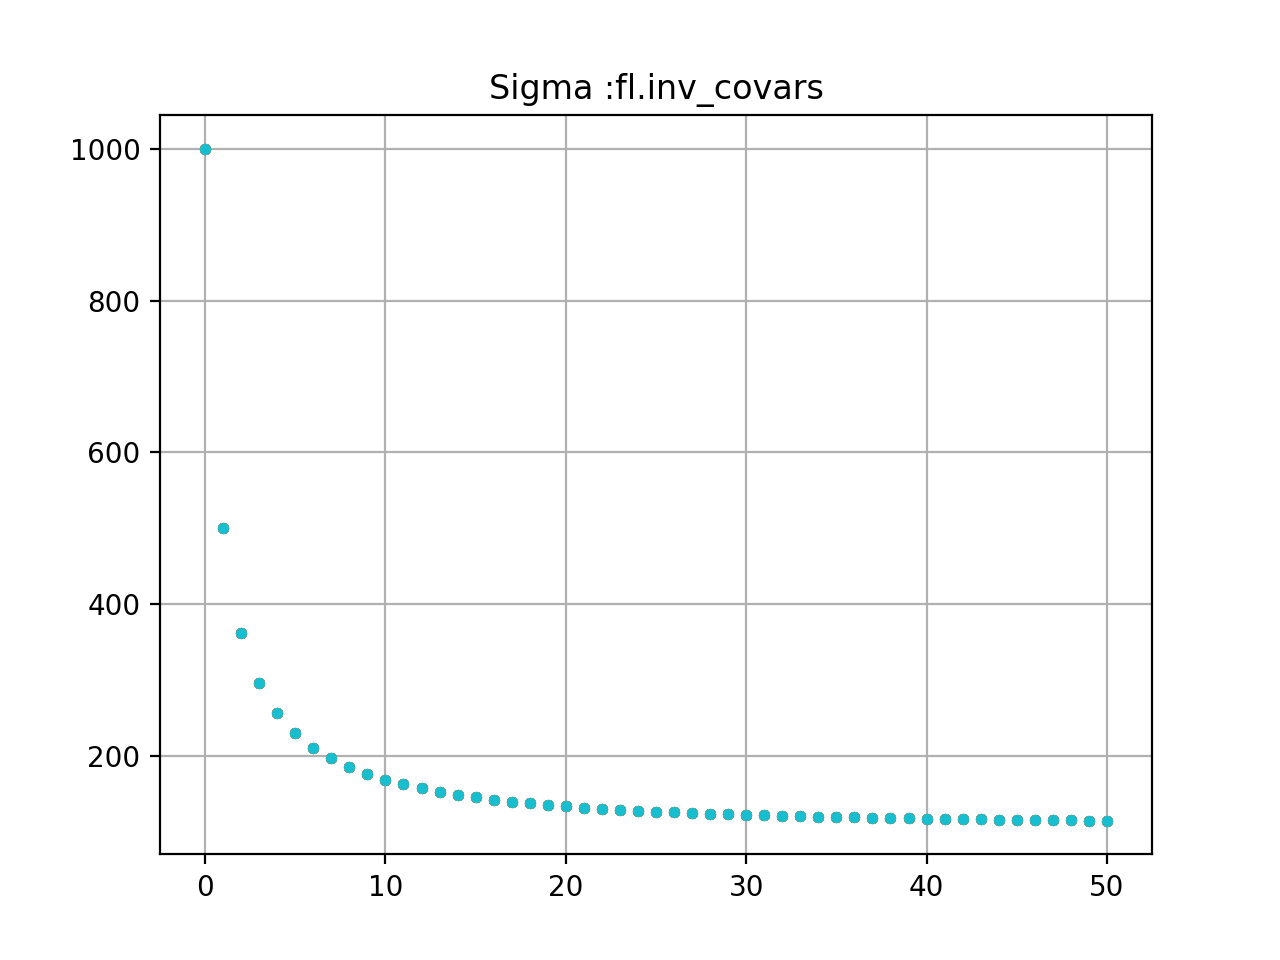

In [35]:
# check that inv_covar went up <=> sigmas went down
fgnl.plot_sigmas_histories(train_res['histories'])

Test set - Average loss: 0.0300, Accuracy: 49536/50000 (99%)
Test set - Average loss: 0.0892, Accuracy: 9753/10000 (98%)


/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_histogram.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)


<IPython.core.display.Javascript object>


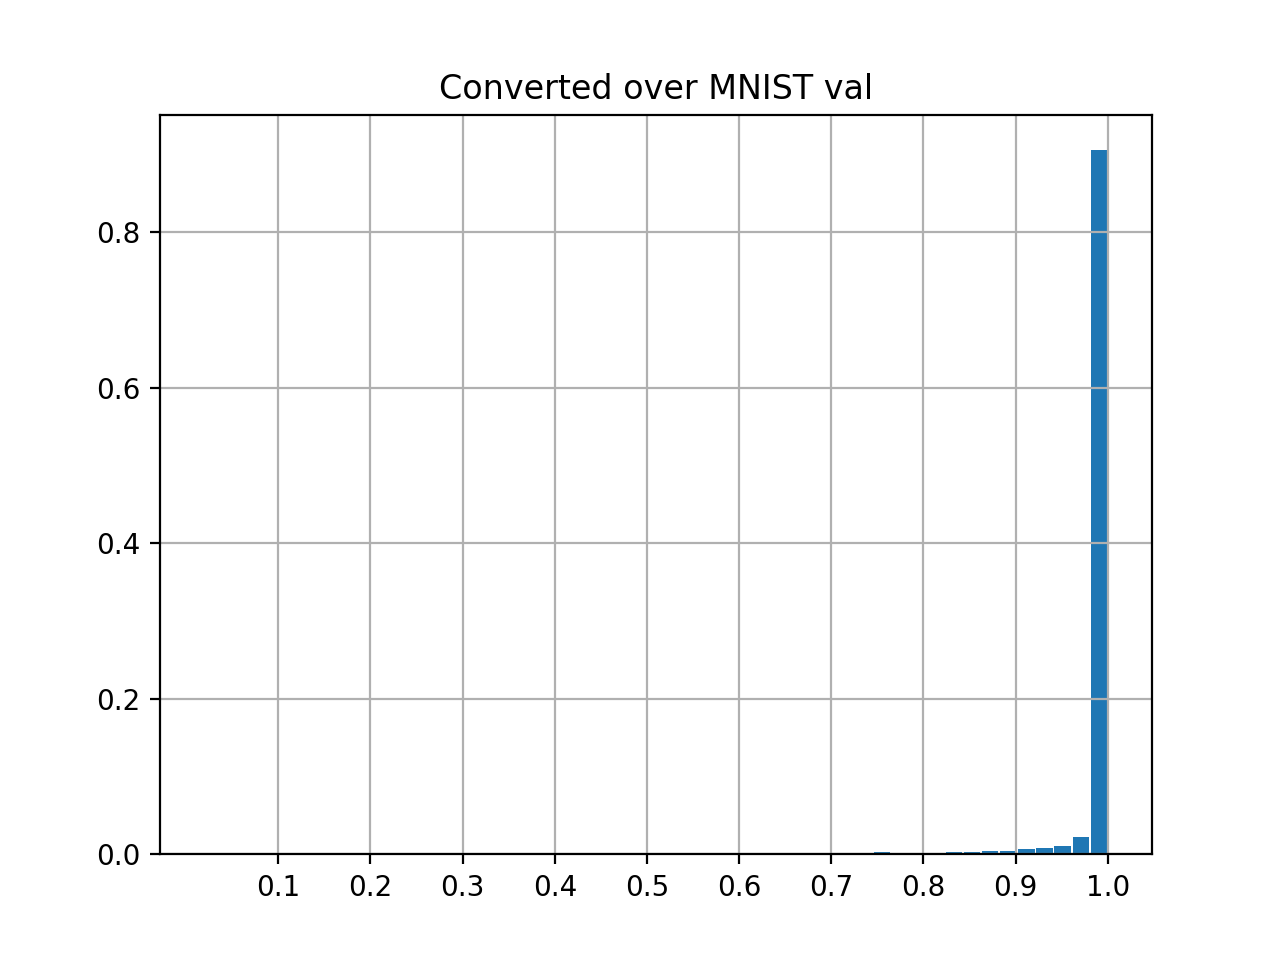

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.10011247353445618128, 0.9999914866231493798), mean=0.9823780012086884855, variance=0.0052910959929628883184, skewness=-5.9819193620048650146, kurtosis=41.54898662195633341)

percentage of confident predictions (>=0.5): 0.9949

Sample predictions
index 230 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 1194 prediction [0.   0.   0.   0.08 0.   0.01 0.   0.   0.   0.91]
index 3085 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 3062 prediction [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.01]
index 6524 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


<IPython.core.display.Javascript object>


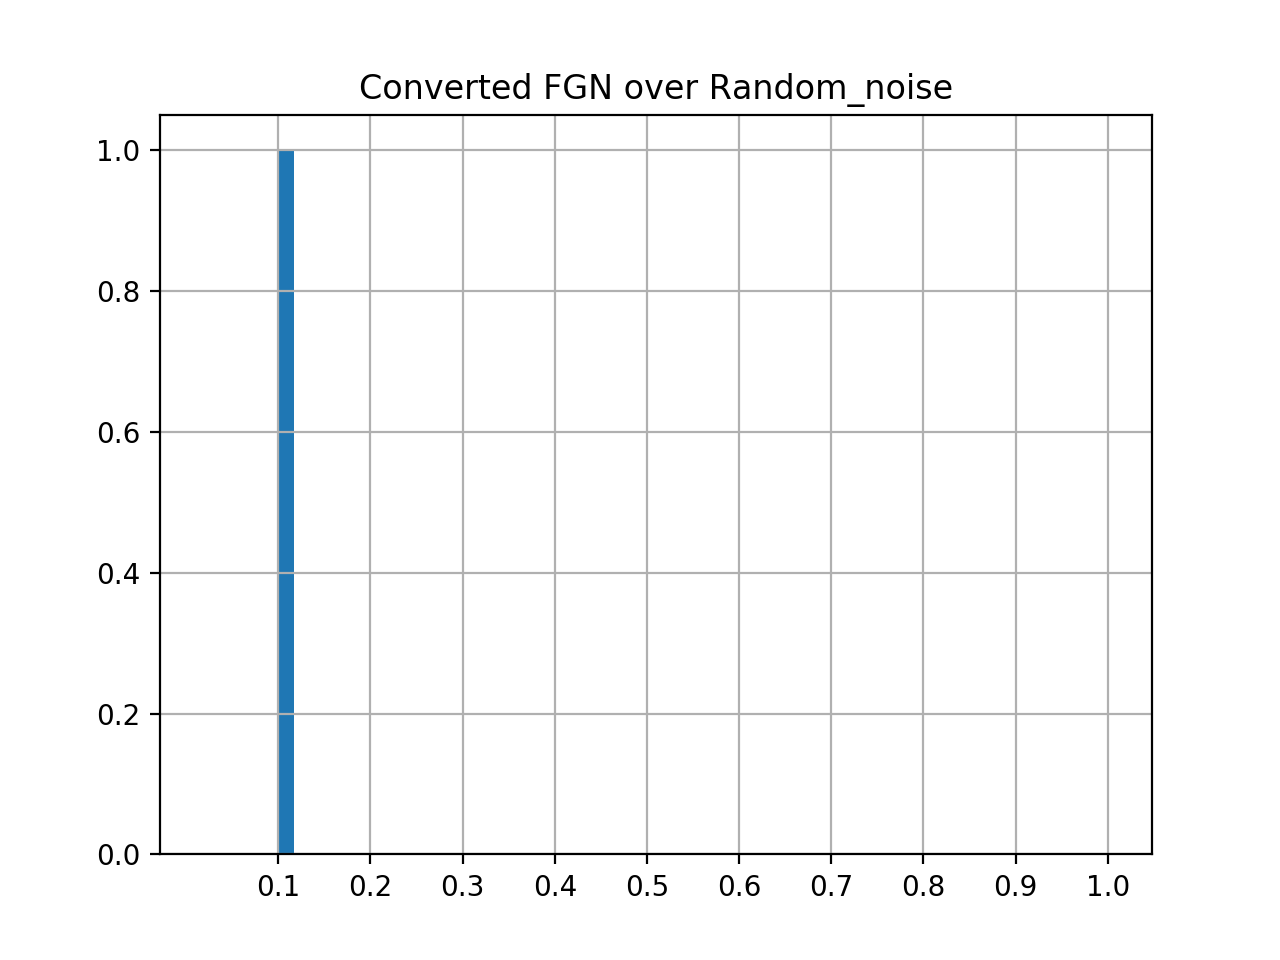

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.1), mean=0.10000000000000000001, variance=4.5922340313026908473e-41, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6917 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8584 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4980 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3019 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2481 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


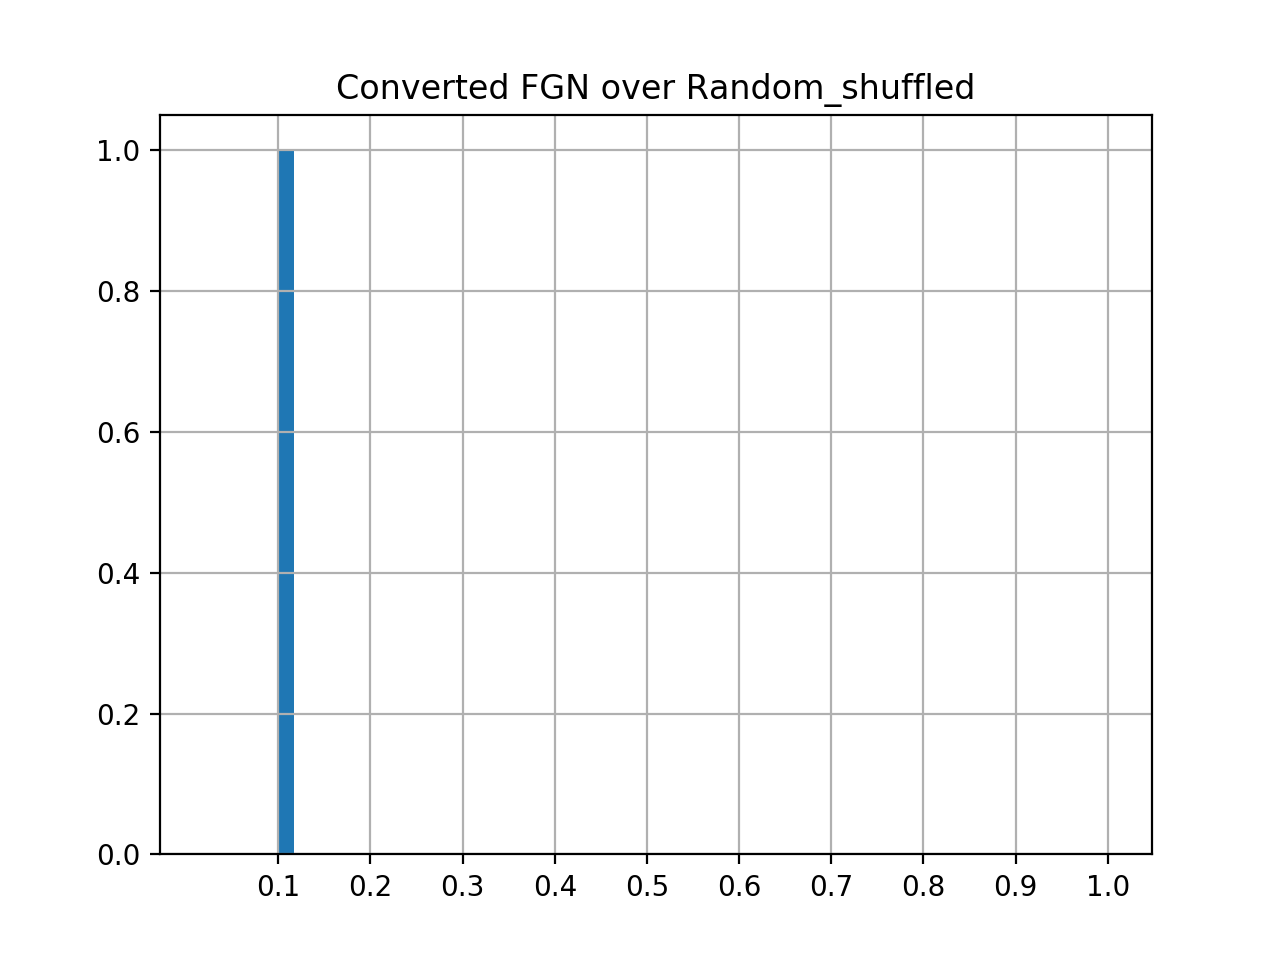

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.109160334458354710685), mean=0.100000916038226578055, variance=8.391172730349766892e-09, skewness=99.984999371073164195, kurtosis=9995.000099492384381)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3034 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5815 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5200 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4386 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6715 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [36]:
# check accuracies
test_res = fgnh.test(converted_fgn_model, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(converted_fgn_model, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)
# check histograms over MNIST, noise, shuffled
fgnh.plot_pred_histogram(converted_fgn_model, mnist_val_loader, title='Converted over MNIST val', verbose=True)
fgnh.plot_pred_histogram(converted_fgn_model, rand_noise_dataloader, title='Converted FGN over Random_noise', verbose=True)
fgnh.plot_pred_histogram(converted_fgn_model, rand_shuffled_dataloader, title='Converted FGN over Random_shuffled', verbose=True)